In [1]:
import xarray as xr
import pathlib
import sys
from data_config import (
    get_scratch_dir,
    get_dask_log_dir,
    get_dask_local_dir,
get_compressed_data_dir
)

import numpy as np

import ndpyramid
import dask
from distributed import Client
import os

In [2]:
scheduler_file = pathlib.Path(os.environ["SCRATCH"]) / "scheduler_file.json"
scheduler_file

PosixPath('/pscratch/sd/a/abanihi/scheduler_file.json')

In [3]:
dask.config.set({"distributed.dashboard.link":  "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status" })

In [4]:
scratch = get_scratch_dir()
dask_log_directory = get_dask_log_dir()
dask_local_directory = get_dask_local_dir()
out_path_prefix = get_compressed_data_dir()

In [5]:
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))

In [6]:
client = Client(scheduler_file=str(scheduler_file))
client

Connection method: Scheduler file,Scheduler file: /pscratch/sd/a/abanihi/scheduler_file.json
Dashboard: /user/abanihi/perlmutter-login-node-base/proxy/10.249.1.185:8787/status,
Comm: tcp://10.249.1.185:8786,Workers: 0
Dashboard: /user/abanihi/perlmutter-login-node-base/proxy/10.249.1.185:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-7152' coro=<Client._gather.<locals>.wait() done, defined at /global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-7109' coro=<Client._gather.<locals>.wait() done, defined at /global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-7033' coro=<Client._gather.<local

In [7]:
out_path_prefix

PosixPath('/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map/research-grade-compressed')

In [25]:
polygon_ids = range(0, 690)
padded_polygon_ids = [f"{polygon_id:03d}" for polygon_id in polygon_ids]
injection_months = [1, 4, 7, 10]
padded_injection_months = [f"{injection_month:02d}" for injection_month in injection_months]


def get_glob_pattern(polygon_id, injection_month):
    glob_template = f'{out_path_prefix}/{{}}/{{}}/*.nc'
    path = glob_template.format(polygon_id, injection_month)
    return path

path = get_glob_pattern(padded_polygon_ids[0], padded_injection_months[0])
path 

'/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map/research-grade-compressed/000/01/*.nc'

In [26]:
%%time
ds = xr.open_mfdataset(path,   
                       coords="minimal",
        combine="by_coords",
        data_vars="minimal", 
        compat="override",
                       decode_times=True, parallel=True)#.chunk({'elapsed_time': -1})
ds = dask.optimize(ds)[0]
ds

OSError: [Errno -51] NetCDF: Unknown file format: '/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map/research-grade-compressed/000/01/*.nc'

- DIC anomaly/full field (only at surface)
    - delta: `ds.DIC.isel(z_t=0) - ds.DIC_ALT_CO2.isel(z_t=0)`
    - experimental: `ds.DIC.isel(z_t=0)`
- DIC (column integrated)
    - delta: `integrate_column(ds.DIC) - integrate_column(ds.DIC_ALT_CO2)`
    - experimental: `integrate_column(ds.DIC)`
- pCO2 (only at surface)
    - delta: `ds.pCO2SURF - ds.pCO2SURF_ALT_CO2`
    - experimental: `ds.pCO2SURF`
- Flux (only at surface)
    - delta: `ds.FG_CO2 - ds.FG_ALT_CO2`
    - experimental: `ds.FG_CO2`
- Surface pH (only at surface)
    - delta: `ds.PH - ds.PH_ALT_CO2`
    - experimental: `ds.PH`

In [10]:
def integrate_column(var: xr.DataArray, depth_element: xr.DataArray) -> xr.DataArray:
    return (var * depth_element).sum(dim='z_t')

In [29]:
def reduction(ds):


    with xr.set_options(keep_attrs=True):

        dic_surf = ds.DIC.isel(z_t=0)
        ds.ALK.isel(z_t=0)
        dic_delta_surf = ds.DIC.isel(z_t=0) - ds.DIC_ALT_CO2.isel(z_t=0)
        ds.ALK.isel(z_t=0) - ds.ALK_ALT_CO2.isel(z_t=0)

        pH_delta_surf = ds.PH - ds.PH_ALT_CO2
        pco2_delta_surf = ds.pCO2SURF - ds.pCO2SURF_ALT_CO2

        fg_co2_delta_surf = ds.FG_CO2 - ds.FG_ALT_CO2

        dic_column_integrated = integrate_column(ds.DIC, ds['dz'] * 1e-3)
        dic_delta_column_integrated = dic_column_integrated - integrate_column(ds.DIC_ALT_CO2, ds['dz'] * 1e-3)

    dso = (
        xr.Dataset(
            dict(
                FG_CO2_SURF=ds.FG_CO2,
                FG_CO2_DELTA_SURF=fg_co2_delta_surf,
                DIC_SURF=dic_surf,
                DIC_DELTA_SURF=dic_delta_surf,
                DIC_COLUMN_INTEGRATED = dic_column_integrated,
                DIC_DELTA_COLUMN_INTEGRATED = dic_delta_column_integrated,
                PH_SURF=ds.PH,
                PH_DELTA_SURF=pH_delta_surf,
                pCO2_DELTA_SURF=pco2_delta_surf,
                pCO2_SURF = ds.pCO2SURF
            )
        )
       
    ).drop_vars(["TLONG", "TLAT"])
    dso.attrs["case"] = ds.title
    return dso


def concatenate_into_bands(ds: xr.Dataset) -> xr.Dataset:
    bands_ds = xr.Dataset(coords=ds.coords)
    
    bands_ds['DIC'] = xr.concat(
        [ds['DIC_DELTA_SURF'], ds['DIC_SURF']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['DIC_INTEGRATED'] = xr.concat(
        [ds['DIC_DELTA_COLUMN_INTEGRATED'], ds['DIC_COLUMN_INTEGRATED']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['PH'] = xr.concat(
        [ds['PH_DELTA_SURF'], ds['PH_SURF']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['FG'] = xr.concat(
        [ds['FG_CO2_DELTA_SURF'], ds['FG_CO2_SURF']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['pCO2SURF'] = xr.concat(
        [ds['pCO2_DELTA_SURF'], ds['pCO2_SURF']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )

    # notice we chunk along the band dimension
    return bands_ds.isel(z_t=0, missing_dims='warn')#.chunk(band=1, nlat=384, nlon=320)


def reshape_into_month_year(ds: xr.Dataset) -> xr.Dataset:

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        reshaped = ds.assign_coords(
            month=xr.DataArray(data=np.concatenate([np.arange(1, 13)] * 15), dims='elapsed_time').astype('int32'), 
            year=xr.DataArray(data=np.repeat(np.arange(1, 16), 12), dims='elapsed_time').astype('int32'),
        ).swap_dims(
            elapsed_time='month',
        ).set_index(
            monthyear=("month", "year"),
        ).unstack(
            'monthyear',
        )

    to_drop_coords = set(reshaped.coords).difference(set(['band', 'elapsed_time', 'injection_date', 'month', 'polygon_id', 'year', 'ULONG', 'ULAT']))
    reshaped['injection_date'] = reshaped.injection_date.dt.month.astype('float32')

    return reshaped.drop_vars(to_drop_coords)

In [30]:
def create_pyramid(polygon_id, store_path='s3://carbonplan-dor-efficiency/store2.zarr'):
    
    for injection_month in padded_injection_months:
        path = get_glob_pattern(polygon_id, injection_month)
        ds = xr.open_mfdataset(path,   
                       coords="minimal",
                        combine="by_coords",
                            data_vars="minimal", 
                            compat="override",
                       decode_times=True, parallel=True)
        ds = dask.optimize(ds)[0]
        bands_ds = ds.pipe(reduction).pipe(concatenate_into_bands).pipe(reshape_into_month_year)
        other_chunks = dict(month=1, year=-1, band=1, polygon_id=1, injection_date=1, x=128, y=128)
        pyramid = ndpyramid.pyramid_regrid(
            bands_ds.chunk(nlat=-1, nlon=-1),
            levels=2,
            projection="web-mercator",
            parallel_weights=False,
            other_chunks=other_chunks,
        )
        
        pyramid = dask.optimize(pyramid)[0]
        pyramid.to_zarr(store_path, region='auto', mode='r+')
        print(f'finished processing polygon_id={polygon_id}, injection_month={injection_month}')
        


In [31]:
%%time
dt  = create_pyramid(padded_polygon_ids[0])

/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=01


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.44 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=04


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.43 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=07


/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/xarray/core/dataset.py:2794: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180, 'band': 2})
  indexers = drop_dims_from_indexers(indexers, self.dims, missing_dims)
/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 14.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


finished processing polygon_id=000, injection_month=10
CPU times: user 1min 3s, sys: 1.84 s, total: 1min 5s
Wall time: 20min 44s


In [17]:
# bands_ds = ds.pipe(reduction).pipe(concatenate_into_bands).pipe(reshape_into_month_year)
# bands_ds

In [18]:
# %%time 

# other_chunks = dict(month=1, year=-1, band=1, polygon_id=1, injection_date=1, x=128, y=128)
# pyramid = ndpyramid.pyramid_regrid(
#     bands_ds.chunk(nlat=-1, nlon=-1),
#     levels=2,
#     projection="web-mercator",
#     parallel_weights=False,
#     other_chunks=other_chunks,
# )

# pyramid = dask.optimize(pyramid)[0]
# pyramid

In [19]:
# pyramid["0"]["FG"].sel(band="experimental").isel(
#     month=0, year=0, polygon_id=0, injection_date=0
# ).plot(robust=True)

In [20]:
# %%time
# path = 's3://carbonplan-dor-efficiency/store2.zarr'
# pyramid.to_zarr(path, region='auto', mode='r+')

In [2]:
path = 's3://carbonplan-dor-efficiency/store2.zarr'
path2 = 's3://carbonplan-oae-efficiency/v2/store2.zarr/'
path = '/pscratch/sd/a/abanihi/store2.zarr'
import xarray as xr
dt = xr.open_datatree(path, engine='zarr', chunks={})
dt

<xarray.DataTree>
Group: /
│   Attributes:
│       multiscales:  [{'datasets': [{'crs': 'EPSG:3857', 'level': 0, 'path': '0'...
│       title:        multiscale data pyramid
│       version:      0.4.0
├── Group: /0
│       Dimensions:         (polygon_id: 690, band: 2, injection_date: 4, month: 12,
│                            year: 15, y: 128, x: 128)
│       Coordinates:
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│         * year            (year) float64 120B 1.0 2.0 3.0 4.0 ... 12.0 13.0 14.0 15.0
│         * band            (band) <U12 96B 'delta' 'experimental'
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * month           (month) float64 96B 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
│         * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
│           elapsed_time    (month, year) float32 720B dask.array<chunksize=(1, 15), meta=np.ndarray>
│         * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
│       Data variables:
│           DIC_INTEGRATED  (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           PH              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           pCO2SURF        (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           FG              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           DIC             (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│       Attributes:
│           multiscales:    [{'datasets': [{'crs': 'EPSG:3857', 'level': 0, 'path': '...
│           regrid_method:  bilinear
└── Group: /1
        Dimensions:         (polygon_id: 690, band: 2, injection_date: 4, month: 12,
                             year: 15, y: 256, x: 256)
        Coordinates:
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
          * year            (year) float64 120B 1.0 2.0 3.0 4.0 ... 12.0 13.0 14.0 15.0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * band            (band) <U12 96B 'delta' 'experimental'
          * month           (month) float64 96B 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
          * polygon_id      (polygon_id) float64 6kB 0.0 1.0 2.0 ... 687.0 688.0 689.0
          * injection_date  (injection_date) float64 32B 1.0 4.0 7.0 10.0
            elapsed_time    (month, year) float32 720B dask.array<chunksize=(1, 15), meta=np.ndarray>
        Data variables:
            DIC_INTEGRATED  (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            PH              (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            pCO2SURF        (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            DIC             (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            FG              (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
        Attributes:
            multiscales:    [{'datasets': [{'crs': 'EPSG:3857', 'level': 1, 'path': '...
            regrid_method:  bilinear

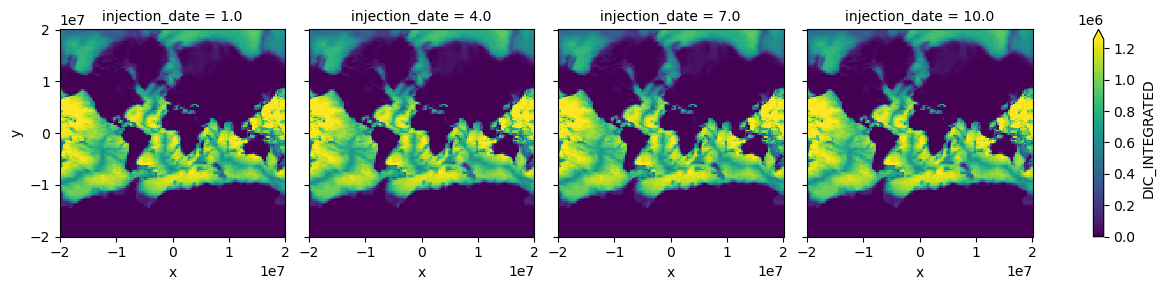

In [5]:
dt["0"]["DIC_INTEGRATED"].sel(band="experimental").isel(
    month=0, year=0, polygon_id=1
).plot(col='injection_date', robust=True)

In [6]:
dt["0"]["DIC_INTEGRATED"].encoding

{'chunks': (1, 1, 1, 1, 15, 128, 128),
 'preferred_chunks': {'polygon_id': 1,
  'band': 1,
  'injection_date': 1,
  'month': 1,
  'year': 15,
  'y': 128,
  'x': 128},
 'compressors': (Zlib(level=1),),
 'filters': (),
 'shards': None,
 '_FillValue': np.float32(9.96921e+36),
 'dtype': dtype('float32'),
 'coordinates': 'elapsed_time'}